# MNIST Semantic Segmentation

## MNISTを加工したセマンティックセグメンテーションのデータセット

In [1]:
import albumentations as A
from albumentations.pytorch import transforms as AT

from dataloaders.segmentation_dataset import SegmentationMNIST

transform = AT.ToTensorV2()     # 前処理の設定
train_val_set = SegmentationMNIST(root='.', threshold=0.2,
                                  transform=transform, fashion=False,
                                  train=True, download=True, )

len(train_val_set)    # 訓練セットと検証セットを合わせたサイズ

60000

In [2]:
image, mask = train_val_set[2]

image.shape, mask.shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

### 画像とマスクの確認

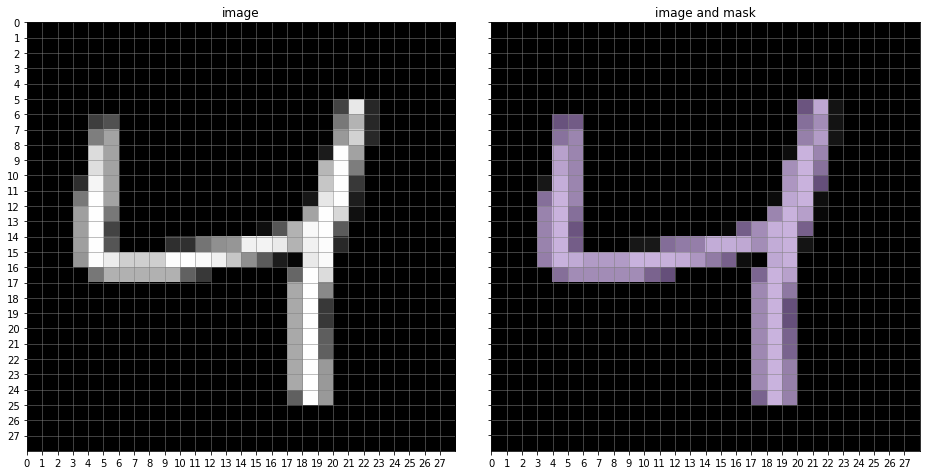

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from visualizations.mask_visualization import make_palette

fig = plt.figure(1, figsize=(16, 8), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.5,
                 )

palette = make_palette()

img = grid[0].imshow(image.permute(1, 2, 0).numpy(), cmap='gray', vmin=0, vmax=1, extent=[0, 28, 28, 0])
grid[0].set_title(f'image')

img = grid[1].imshow(image.permute(1, 2, 0).numpy(), cmap='gray', vmin=0, vmax=1, extent=[0, 28, 28, 0])
img = grid[1].imshow(palette[mask].numpy(), alpha=0.5, extent=[0, 28, 28, 0])
grid[1].set_title(f'image and mask')

for i in range(2):
    grid[i].set_xticks(np.arange(0, 28, 1))
    grid[i].set_yticks(np.arange(0, 28, 1))
    grid[i].set_xticklabels(np.arange(0, 28, 1))
    grid[i].set_yticklabels(np.arange(0, 28, 1))
    grid[i].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)
    
plt.show()

## データ拡張の挙動

In [4]:
from torch.utils.data import random_split

# 訓練データセット:検証データセット = 5:1 に分割する
train_size = len(train_val_set) * 5 // 6
val_size = len(train_val_set) - train_size

# ランダム分割で訓練セットと検証セットを作成
train_set, val_set = random_split(train_val_set, [train_size, val_size])

len(train_set), len(val_set)  # 訓練セットと検証セットのサイズ

(50000, 10000)

In [5]:
# 訓練データセットと検証データセットのデータセットの実体は同一オブジェクト
id(train_set.dataset), id(val_set.dataset)

(140053522863584, 140053522863584)

In [6]:
from copy import deepcopy

# データ拡張のために訓練セットのオブジェクトをディープコピーする
train_set.dataset = deepcopy(train_set.dataset)

# ランダムアフィン変換のデータ拡張
train_set.dataset.transform = A.Compose([
    A.Affine(scale=(0.85, 1.15), translate_px=(-2, 2), rotate=(-10, 10), shear=(-15, 15), always_apply=True),
    AT.ToTensorV2()
])

# 異なるオブジェクトになったことを確認
id(train_set.dataset), id(val_set.dataset)

(140049219530816, 140053522863584)

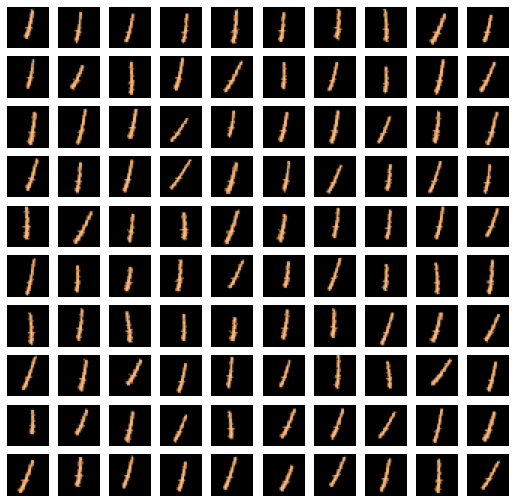

In [7]:
import math

images = []
masks = []
for i in range(100):
    image, mask = train_set[0]
    images.append(image)
    masks.append(mask)

fig = plt.figure(figsize=(9, 9), facecolor='white')
nrows = 10
ncols = math.ceil(len(images) / nrows)

for i, (image, mask) in enumerate(zip(images, masks)):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis('off')

    ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray', extent=[0, 28, 28, 0])
    ax.imshow(palette[mask].numpy(), alpha=0.5, extent=[0, 28, 28, 0])

plt.show()

## DataLoaderの挙動

In [8]:
from torch.utils.data import DataLoader

batch_size = 100    # ミニバッチサイズは100

# 訓練データローダーと検証データローダーを作成
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)

len(train_loader), len(val_loader)     # ミニバッチの個数

(500, 100)

In [9]:
images, masks = next(iter(train_loader))  # 訓練ローダーの最初の1ミニバッチ

images.shape, masks.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100, 28, 28]))

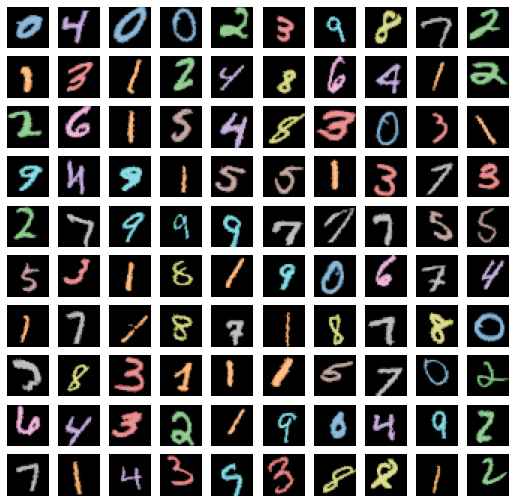

In [10]:
fig = plt.figure(figsize=(9, 9), facecolor='white')
nrows = 10
ncols = math.ceil(len(images) / nrows)

for i, (image, mask) in enumerate(zip(images, masks)):
    ax = plt.subplot(10, 10, i+1)
    ax.axis('off')

    ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray', extent=[0, 28, 28, 0])
    ax.imshow(palette[mask].numpy(), alpha=0.5, extent=[0, 28, 28, 0])

plt.show()

## セマンティックセグメンテーション用ネットワークの設定

In [11]:
from models.simple_unet import SimpleUNet

in_channels = 1
num_foreground = 10
num_classes = num_foreground + 1

net = SimpleUNet(in_channels, num_classes)

In [12]:
import torch

# 学習に使用するデバイスの設定。CPU or GPU、GPUが使用できない場合は自動的にCPU設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

In [13]:
# ニューラルネットワークをデバイスに送る。デバイスがCPUの場合は実質変更なし
net.to(device)

SimpleUNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (bottle_neck): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, paddi

## 損失関数、評価関数、最適化アルゴリズムの設定

In [14]:
from torch import nn
from torch import optim

from metrics.segmentation_metric import MaskScoring

# 損失関数の設定
criterion = nn.CrossEntropyLoss()   # ソフトマックス交差エントロピー

# 評価関数の設定
metric = MaskScoring(num_classes)

# 最適化アルゴリズムの設定
learning_rate = 1e-3    # 学習率
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## 学習の実行

In [15]:
import os
from routines.segmentation_routine import run_segmentation

# 保存先の作成
os.makedirs('results/mnist_segmentation', exist_ok=True)

max_epoch = 20

for epoch in range(1, max_epoch+1):
    # 訓練実行
    run_segmentation('train', epoch, train_loader, device, net, criterion, metric, optimizer=optimizer)
        
    # 検証実行
    run_segmentation('val', epoch, val_loader, device, net, criterion, metric)

# 学習したニューラルネットワークのパラメータを保存
net.to('cpu')
torch.save(net.state_dict(), f'results/mnist_segmentation/model_epoch{epoch}.pth')

train [mini-batches: 50, images: 5000] loss: 0.7064
train [mini-batches: 100, images: 10000] loss: 0.2745
train [mini-batches: 150, images: 15000] loss: 0.1413
train [mini-batches: 200, images: 20000] loss: 0.1498
train [mini-batches: 250, images: 25000] loss: 0.1001
train [mini-batches: 300, images: 30000] loss: 0.0792
train [mini-batches: 350, images: 35000] loss: 0.0846
train [mini-batches: 400, images: 40000] loss: 0.0674
train [mini-batches: 450, images: 45000] loss: 0.0722
train [mini-batches: 500, images: 50000] loss: 0.0633
Epoch: 1/train  loss: 0.2550  TP: 4913648  FP: 1435073  FN: 1273406

val [mini-batches: 10, images: 1000] loss: 0.0450
val [mini-batches: 20, images: 2000] loss: 0.0521
val [mini-batches: 30, images: 3000] loss: 0.0494
val [mini-batches: 40, images: 4000] loss: 0.0511
val [mini-batches: 50, images: 5000] loss: 0.0357
val [mini-batches: 60, images: 6000] loss: 0.0398
val [mini-batches: 70, images: 7000] loss: 0.0535
val [mini-batches: 80, images: 8000] loss: 

## 推論の実行

In [16]:
net.load_state_dict(torch.load(f'results/mnist_segmentation/model_epoch{epoch}.pth'))
net.to(device)

SimpleUNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (bottle_neck): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, paddi

In [17]:
transform = AT.ToTensorV2()

# テストセットの設定
test_set = SegmentationMNIST(root='.', threshold=0.2,
                             transform=transform, fashion=False,
                             train=False, download=True, )

# テストローダーの設定
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=4)

In [18]:
# テスト実行
run_segmentation('test', None, test_loader, device, net, criterion, metric)

test [mini-batches: 10, images: 1000] loss: 0.0171
test [mini-batches: 20, images: 2000] loss: 0.0172
test [mini-batches: 30, images: 3000] loss: 0.0138
test [mini-batches: 40, images: 4000] loss: 0.0154
test [mini-batches: 50, images: 5000] loss: 0.0125
test [mini-batches: 60, images: 6000] loss: 0.0192
test [mini-batches: 70, images: 7000] loss: 0.0121
test [mini-batches: 80, images: 8000] loss: 0.0126
test [mini-batches: 90, images: 9000] loss: 0.0134
test [mini-batches: 100, images: 10000] loss: 0.0141
test  loss: 0.0163  TP: 1246082  FP: 20488  FN: 32799



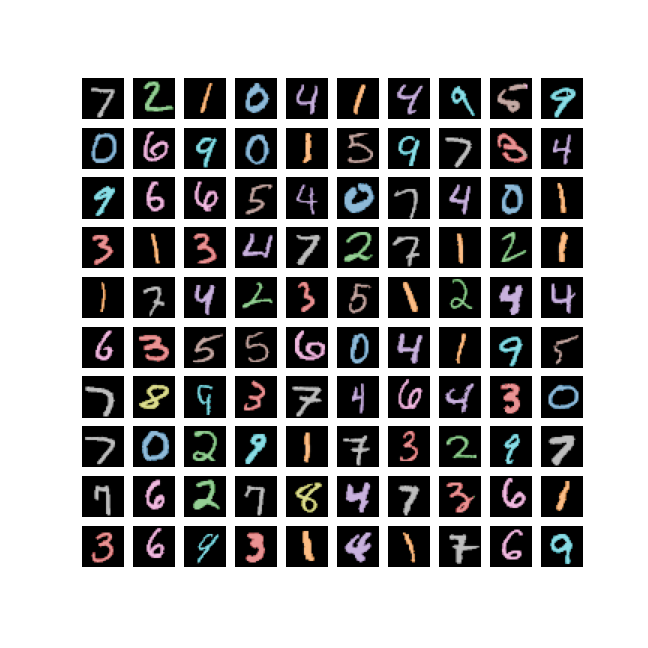

In [19]:
from PIL import Image

# 推論結果のクラスで着色している
Image.open('results/mnist_segmentation/test.png')

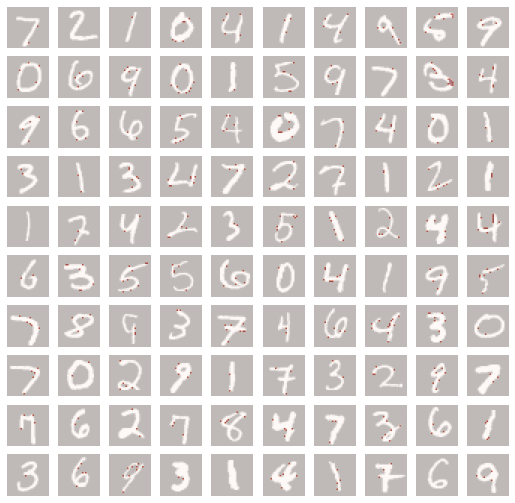

In [20]:
from torch.nn import functional as F

# 誤りを可視化するために再び推論する

images, masks = next(iter(test_loader))     # テストローダーの最初の1ミニバッチ
images = images.to(device)
masks = masks.to(device)
with torch.no_grad():
    logits = net(images)
    loss = criterion(logits, masks)
    predicted_masks = torch.argmax(logits, dim=1)
images = images.detach().cpu()
masks = masks.detach().cpu()
predicted_masks = predicted_masks.cpu()

fig = plt.figure(figsize=(9, 9), facecolor='white')
nrows = 10
ncols = math.ceil(len(images) / nrows)

for i, (image, mask, predicted_mask) in enumerate(zip(images, masks, predicted_masks)):
    ax = plt.subplot(10, 10, i+1)
    ax.axis('off')

    ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray', alpha=0.5, extent=[0, 28, 28, 0])
    
    mask = F.one_hot(mask, num_classes)     # one-hoe化。チャネルの軸は末尾
    predicted_mask = F.one_hot(predicted_mask, num_classes)
    error = torch.logical_xor(mask, predicted_mask).sum(dim=-1)     # 一致しなかった位置がTrue
    
    ax.imshow(error.numpy(), cmap='Reds', alpha=0.5, extent=[0, 28, 28, 0])

plt.show()

## 補足：マスクのさまざまな画像表示方法

### ブールインデックスでRGB画像に変換

In [21]:
# Tensorのパレットを作成する
palette = make_palette()

palette

tensor([[  0,   0,   0],
        [ 31, 119, 180],
        [255, 127,  14],
        [ 44, 160,  44],
        [214,  39,  40],
        [148, 103, 189],
        [140,  86,  75],
        [227, 119, 194],
        [127, 127, 127],
        [188, 189,  34],
        [ 23, 190, 207]])

In [22]:
from torchvision import utils as VU

# TensorのパレットにマスクでインデクシングすることでRGB化する
color_masks = palette[masks]    # [100, 28, 28, 3]
color_masks = color_masks.permute(0, 3, 1, 2)   # [100, 3, 28, 28]

# Torchvisionのmake_gridで1枚の画像にする
grid_masks = VU.make_grid(color_masks, nrow=10)     # [3, 302, 302]

# NumPy ndarrayに変換
np_grid_masks = grid_masks.permute(1, 2, 0).numpy().astype(np.uint8)    # [302, 302, 3]

np_grid_masks.shape

(302, 302, 3)

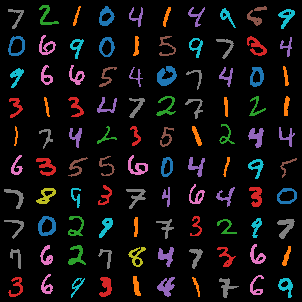

In [23]:
from PIL import Image

# PIL画像に変換
pil_grid_masks = Image.fromarray(np_grid_masks)

pil_grid_masks

### scikit-imageを使ったRGB画像化

In [24]:
# NumPy ndarrayのパレットを作成する。ただし背景抜き
tab10 = plt.get_cmap('tab10')
np_palette = np.array([tab10(i) for i in range(tab10.N)])

np_palette

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]])

In [25]:
from skimage.color import label2rgb

# label2rgbでRGB化する
color_masks = label2rgb(masks.numpy(), colors=np_palette,
                        bg_label=0, bg_color=[0, 0, 0])     # [100, 28, 28, 3]

color_masks = color_masks.transpose(0, 3, 1, 2)     # [100, 3, 28, 28]
color_masks = torch.tensor(color_masks)

# Torchvisionのmake_gridで1枚の画像にする
grid_masks = VU.make_grid(color_masks, nrow=10)     # [3, 302, 302]
grid_masks *= 255

# NumPy ndarrayに変換
np_grid_masks = grid_masks.permute(1, 2, 0).numpy().astype(np.uint8)

np_grid_masks.shape

(302, 302, 3)

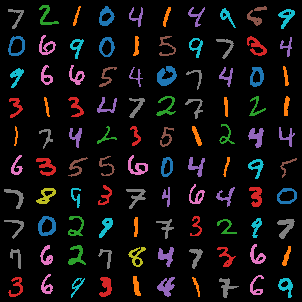

In [26]:
# PIL画像に変換
pil_grid_masks = Image.fromarray(np_grid_masks)

pil_grid_masks

### インデックスカラー画像化

In [27]:
# マスクをインデックスカラーで表示するためのカラーパレットを作る
tab10 = plt.get_cmap('tab10')
cmap = [(0., 0., 0., 1.)]   # 背景
for n in range(tab10.N):
    cmap.append(tab10(n))

np_palette = np.array(cmap)[:, :3].flatten()   # alphaは抜いてRGBのみをフラット化
np_palette = (255 * np_palette).astype(np.uint8)

np_palette

array([  0,   0,   0,  31, 119, 180, 255, 127,  14,  44, 160,  44, 214,
        39,  40, 148, 103, 189, 140,  86,  75, 227, 119, 194, 127, 127,
       127, 188, 189,  34,  23, 190, 207], dtype=uint8)

In [28]:
# Torchvisionのmake_gridで1枚の画像にする
grid_masks = VU.make_grid(masks.unsqueeze(dim=1), nrow=10)  # [3, 302, 302]
grid_masks = grid_masks[0]  # [302, 302]

# NumPy ndarrayに変換
np_grid_masks = grid_masks.numpy().astype(np.uint8)

np_grid_masks.shape

(302, 302)

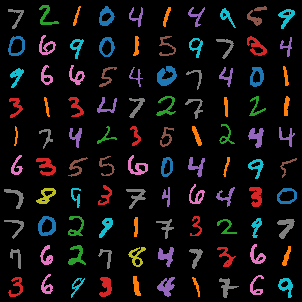

In [29]:
# PモードのPIL画像に変換
pil_grid_masks = Image.fromarray(np_grid_masks).convert('P')

# PIL画像にパレットを付ける
pil_grid_masks.putpalette(np_palette)

pil_grid_masks